In [21]:
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

dvc = torch.device("cuda" if torch.cuda.is_available() else "cpu")

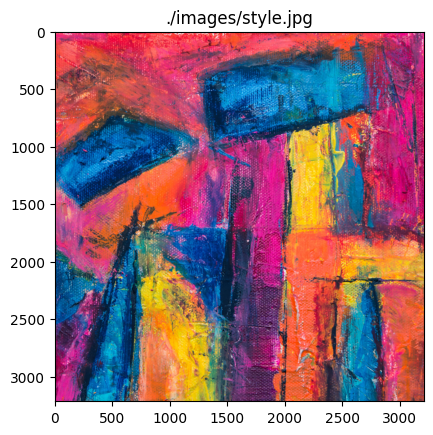

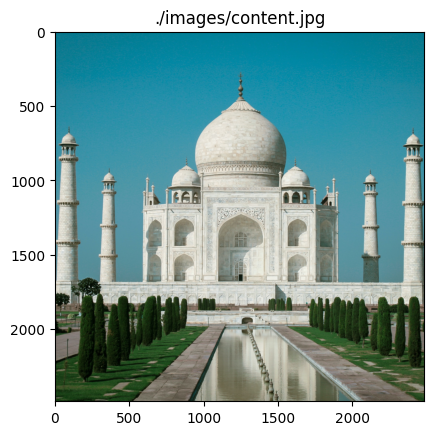

In [3]:
def image_to_tensor(image_filepath, image_dimension=128):
    img = Image.open(image_filepath).convert('RGB')
    
    # display image to check 
    plt.figure()
    plt.title(image_filepath)
    plt.imshow(img)
    
    if max(img.size) <= image_dimension:
        img_size = max(img.size)
    else:
        img_size = image_dimension
  
    torch_transformation = torchvision.transforms.Compose([
        torchvision.transforms.Resize(img_size),
        torchvision.transforms.ToTensor()
    ])
  
    img = torch_transformation(img).unsqueeze(0)
  
    return img.to(dvc, torch.float)

style_image = image_to_tensor("./images/style.jpg")
content_image = image_to_tensor("./images/content.jpg")

## define gram matrix

In [4]:
def gram_matrix(ip):
    num_batch, num_channels, height, width = ip.size()
    feats = ip.view(num_batch * num_channels, width * height)
    gram_mat = torch.mm(feats, feats.t()) 
    return gram_mat.div(num_batch * num_channels * width * height)

## pretrained model

In [5]:
vgg19_model = torchvision.models.vgg19(pretrained=True).to(dvc)
print(vgg19_model)

C:\Users\jrbir\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jrbir\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\jrbir/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 74.2MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [6]:
vgg19_model = vgg19_model.features

In [7]:
for param in vgg19_model.parameters():
    param.requires_grad_(False)

## refine model for this task

### change maxpool layers to avgpool

In [8]:
conv_indices = []

for i in range(len(vgg19_model)):
    if vgg19_model[i]._get_name() == 'MaxPool2d':
        vgg19_model[i] = nn.AvgPool2d(kernel_size=vgg19_model[i].kernel_size, 
                                      stride=vgg19_model[i].stride, 
                                      padding=vgg19_model[i].padding)
    if vgg19_model[i]._get_name() == 'Conv2d':
        conv_indices.append(i)
        
conv_indices = dict(enumerate(conv_indices, 1))
print(vgg19_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (19): Conv2d(256

### clip until the last relevant layer

In [9]:
layers = {1: 's', 2: 's', 3: 's', 4: 'sc', 5: 's'}

In [10]:
vgg_layers = nn.ModuleList(vgg19_model)

last_layer_idx = conv_indices[max(layers.keys())]
vgg_layers_trimmed = vgg_layers[:last_layer_idx+1]

neural_style_transfer_model = nn.Sequential(*vgg_layers_trimmed)
print(neural_style_transfer_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


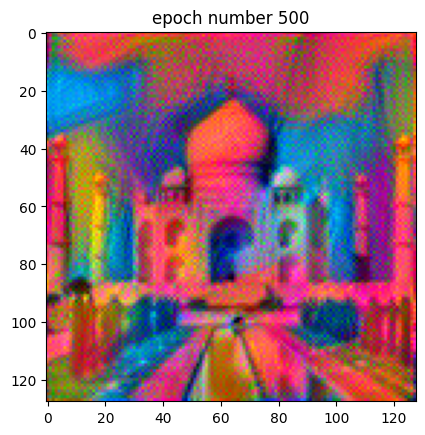

In [40]:
ip_image = torch.randn(content_image.data.size(), device=dvc)
#plt.figure()
#plt.imshow(ip_image.squeeze(0).cpu().detach().numpy().transpose(1,2,0).clip(0,1));

num_epochs=500
wt_style=1e6
wt_content=1
style_losses = []
content_losses = []
opt = optim.Adam([ip_image.requires_grad_()], lr=0.1)

for curr_epoch in range(1, num_epochs+1):
    
    ip_image.data.clamp_(0, 1)
    opt.zero_grad()
    epoch_style_loss = 0
    epoch_content_loss = 0

    for k in layers.keys():
        if 'c' in layers[k]:
            target = neural_style_transfer_model[:conv_indices[k]+1](content_image).detach()
            ip = neural_style_transfer_model[:conv_indices[k]+1](ip_image)
            epoch_content_loss += torch.nn.functional.mse_loss(ip, target)
        if 's' in layers[k]:
            target = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](style_image)).detach()
            ip = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](ip_image))
            epoch_style_loss += torch.nn.functional.mse_loss(ip, target)

    epoch_style_loss *= wt_style
    epoch_content_loss *= wt_content
    total_loss = epoch_style_loss + epoch_content_loss
    total_loss.backward()
    
    # if curr_epoch % 100 == 0:
    #     print(f"epoch number {curr_epoch}")
    #     print(f"style loss = {epoch_style_loss}, content loss = {epoch_content_loss}")
    #     plt.figure()
    #     plt.title(f"epoch number {curr_epoch}")
    #     plt.imshow(ip_image.data.clamp_(0, 1).squeeze(0).cpu().detach().numpy().transpose(1,2,0))
    #     plt.show()
    #     # style_losses += [epoch_style_loss.detach().numpy()]
    #     # content_losses += [epoch_content_loss.detach().numpy()]
    #     style_losses += [epoch_style_loss.detach().cpu().numpy()]
    #     content_losses += [epoch_content_loss.detach().cpu().numpy()]

    opt.step()

plt.figure()
plt.title(f"epoch number {curr_epoch}")
plt.imshow(ip_image.data.clamp_(0, 1).squeeze(0).cpu().detach().numpy().transpose(1,2,0))
plt.show()

ValueError: x and y must have same first dimension, but have shapes (6,) and (5,)

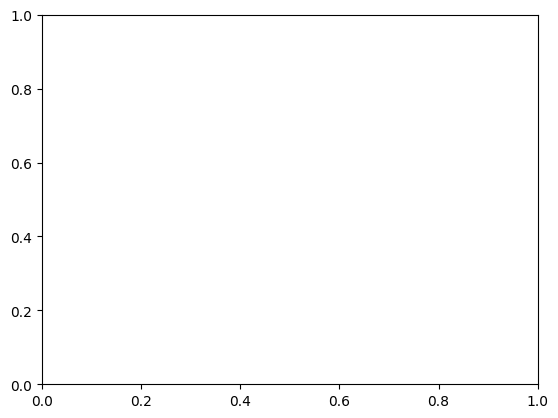

In [20]:
plt.plot(range(50, 300+1, 50), style_losses, label='style_loss');
plt.plot(range(50, 300+1, 50), content_losses, label='content_loss');
plt.legend();